# Projekt Data Analytics
## Przewidywanie i analiza stanu cywilnego ludności USA na przestrzeni lat 

Autorzy: Julia Nowak, Adam Złocki

### 1. Sformuowanie problemu


##### Główny problem
Celem projektu jest predykcja procentowego udziału dorosłych osób po ślubie, rozwiedzionych oraz takich, które nigdy nie brały ślubu w społeczeństwie USA.
Problem nie skupia się na konkretnych rasach ludzi – przyjęte zostały dane ogólne,
wspólne dla wszystkich ras. Dobrany zestaw danych umożliwia jednak podzielenie danych na konkretne rasy oraz odrębną analizę stanu cywilnego. Idea projektu została oparta o aktualny temat dotyczący hipotetycznego spadku liczby małżeństw oraz wzrostu liczby rozwodów
w krajach wysoko rozwiniętych, takich jak USA. Podczas analizy chcemy wykazać istniejące trendy oraz przewidzieć rozkład interesujących nas wartości w przyszłości.

##### Przykłady użycia i powody analizy
Problem predykcji stanu cywilnego oraz przewidywanie procentowej ilości m.in. małżeństw
w społeczeństwie jest z punktu widzenia państwa niezwykle istotną informacją.
Jest to problem, który warto analizować chociażby pod kątem planowania przez rząd Stanów Zjednoczonych polityki prorodzinnej. Temat jest istotny także przy wszelkiego rodzaju oszacowaniach związanych z przyrostem naturalnym czy uwarunkowaniami społecznymi. Analiza może wskazać rządowi ze znacznym wyprzedzeniem, iż w społeczeństwie zachodzą pewne zmiany, które warto wziąć pod uwagę przy tworzeniu przyszłych planów.

##### Pochodzenie i zawartość danych
Dane, które są przez nas wykorzystywane, pochodzą z oficjalnej strony rządowej USA (www.census.gov). Zawierają one informacje o liczbie osób o danym stanie cywilnym w zależności od roku, średnim wieku zawarcia pierwszego małżeństwa oraz o całkowitym, średnim przychodzie na członka gospodarstwa domowego w celu zaprezentowania ogólnej sytuacji materialnej społeczeństwa. Dane dotyczące liczby ludności wymagają ustandaryzowania, ze względu na zmieniającą się sumaryczną wartość – stąd logiczne wydaje się operowanie na wartościach procentowych.
Dodatkowo dostępne są również identyczne dane z uwzględnieniem podziału na rasy,
a więc możliwe jest przeprowadzenie predykcji dla każdej z nich osobno, a następnie wykonanie analizy porównawczej, zarówno rzeczywistych, jak i przewidywanych wartości.
Wykorzystywane przez nas dane są danymi historycznymi, uzupełnianymi od XX wieku do 2023 roku. Ich ostatnia aktualizacja miała miejsce w listopadzie 2023 roku – są to więc dane stosunkowo świeże. Do analizy przyjęte zostały lata 2020 – 2022, z pominięciem duplikatów niektórych lat (z każdej pary wybrano dane odświeżone).
Dane uwzględniają różne tabele pochodzące z Ankiet Obecnej Populacji (ang. Current Population Survey; CPS), przeprowadzanych co roku przez cenzus w USA.

##### Schemat DAG
TO  DO


### 2. Preprocessing - wstępne przetwarzanie danych

- is preprocessing step clearly described [1 pt]
- reasoning and types of actions taken on the dataset have been described [1 pt]

1. Wybranie analizowanych lat oraz rasy:
- wybrano lata 1993 - 2022 (prawie 30 lat do analizy)
- lata 2018-2023 zostały przeznaczone do oceny działania modelu
- skupiono się na analizie ogólnej wszystkich ras

2. Uwagi do danych:
- w przypadku lat 2021 oraz 2011 w danych wystąpiły podwójne wyniki, ze względu na to, iż zaprezentowano wyniki pierwotne oraz zaktualizowane na podstawie populacji z ostatniego spisu powszechnego co dziesięciolecie (przyjęto zaktualizowane wartości)
- w roku 2014 nastąpiła zmiana pytań odnośnie przychodu i ubezpieczenia zdrowotnego, a więc część pytań zadanych ankietowanym się różniła
- od 2019 uwzględniono również małżeństwa homoseksualne

3. Usuwanie i operacje:
- Rok zmieniono z "..2011" do formy bez kropek
- usunięto rok 2023 ze względu na przychód z lat poprzednich
- usunięto zduplikowane lata
- połączono dane tak, aby pominąć kwestię płci
- wyliczono całość badanych (z uzględnieniem danych spoza analizowanych)
- household wybrano z odrębnej bazy danych dla lepszych wyników
- przekształcenie lat na liczby, ujednolicenie typów danych


##### Import niezbędnych bibliotek

In [251]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [252]:
# df = pd.read_excel("data.xlsx", sheet_name="Normalized_data")
df = pd.read_excel("data.xlsx", sheet_name="Raw_data")
df = df[['Year', 'Married', 'Income per member', "Mean age", "Household", "Total", "Income"]]

In [253]:
df_all = df
df = df[:25]
df.head()

,Year,Married,Income per member,Mean age,Household,Total,Income
0,1993,114601,15500,25.50,96391,197254,78140
1,1994,115253,16300,25.60,97107,200800,79610
2,1995,116554,16940,25.70,98990,202732,81030
3,1996,116561,17850,25.95,99627,204624,82780
4,1997,116752,18940,25.90,101018,207235,85460


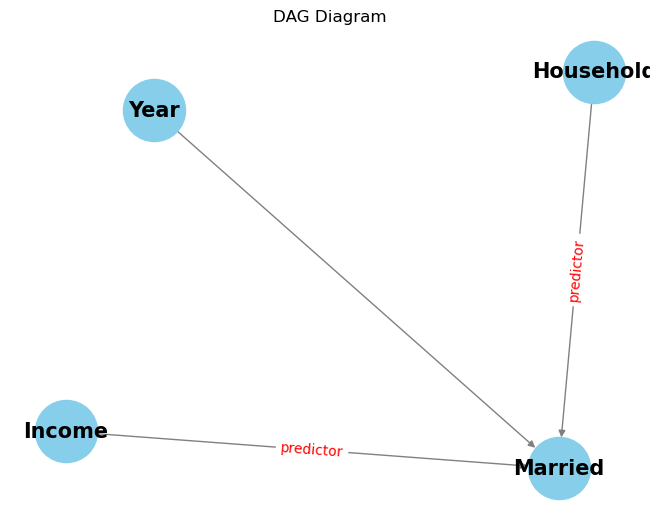

In [254]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Income")
G.add_node("Household")
G.add_node("Married")

# Add edges
G.add_edge("Year", "Married")
G.add_edge("Income", "Married")
G.add_edge("Household", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

# Add edge labels
edge_labels = {
    ("Income", "Married"): "predictor",
    ("Household", "Married"): "predictor"
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("DAG Diagram")
plt.show()


In [255]:
df.describe()

,Year,Married,Income per member,Mean age,Household,Total,Income
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000,229046.720000,89721.600000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469,19449.196392,5602.720083
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000,78140.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000,211676.000000,87980.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000,230272.000000,89920.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000,245275.000000,91810.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000,259063.000000,103300.000000


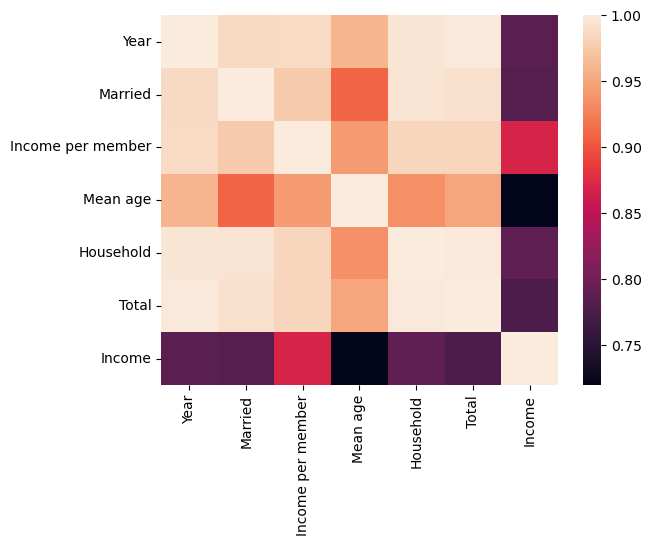

In [256]:
new = df.corr()
sns.heatmap(new)
plt.show()

In [257]:
new

,Year,Married,Income per member,Mean age,Household,Total,Income
Year,1.000000,0.985780,0.987215,0.959830,0.995586,0.998708,0.785702
Married,0.985780,1.000000,0.975002,0.908546,0.994404,0.991485,0.782517
Income per member,0.987215,0.975002,1.000000,0.942462,0.984074,0.983914,0.868952
Mean age,0.959830,0.908546,0.942462,1.000000,0.935904,0.950156,0.719628
Household,0.995586,0.994404,0.984074,0.935904,1.000000,0.998158,0.789043
Total,0.998708,0.991485,0.983914,0.950156,0.998158,1.000000,0.775840
Income,0.785702,0.782517,0.868952,0.719628,0.789043,0.775840,1.000000


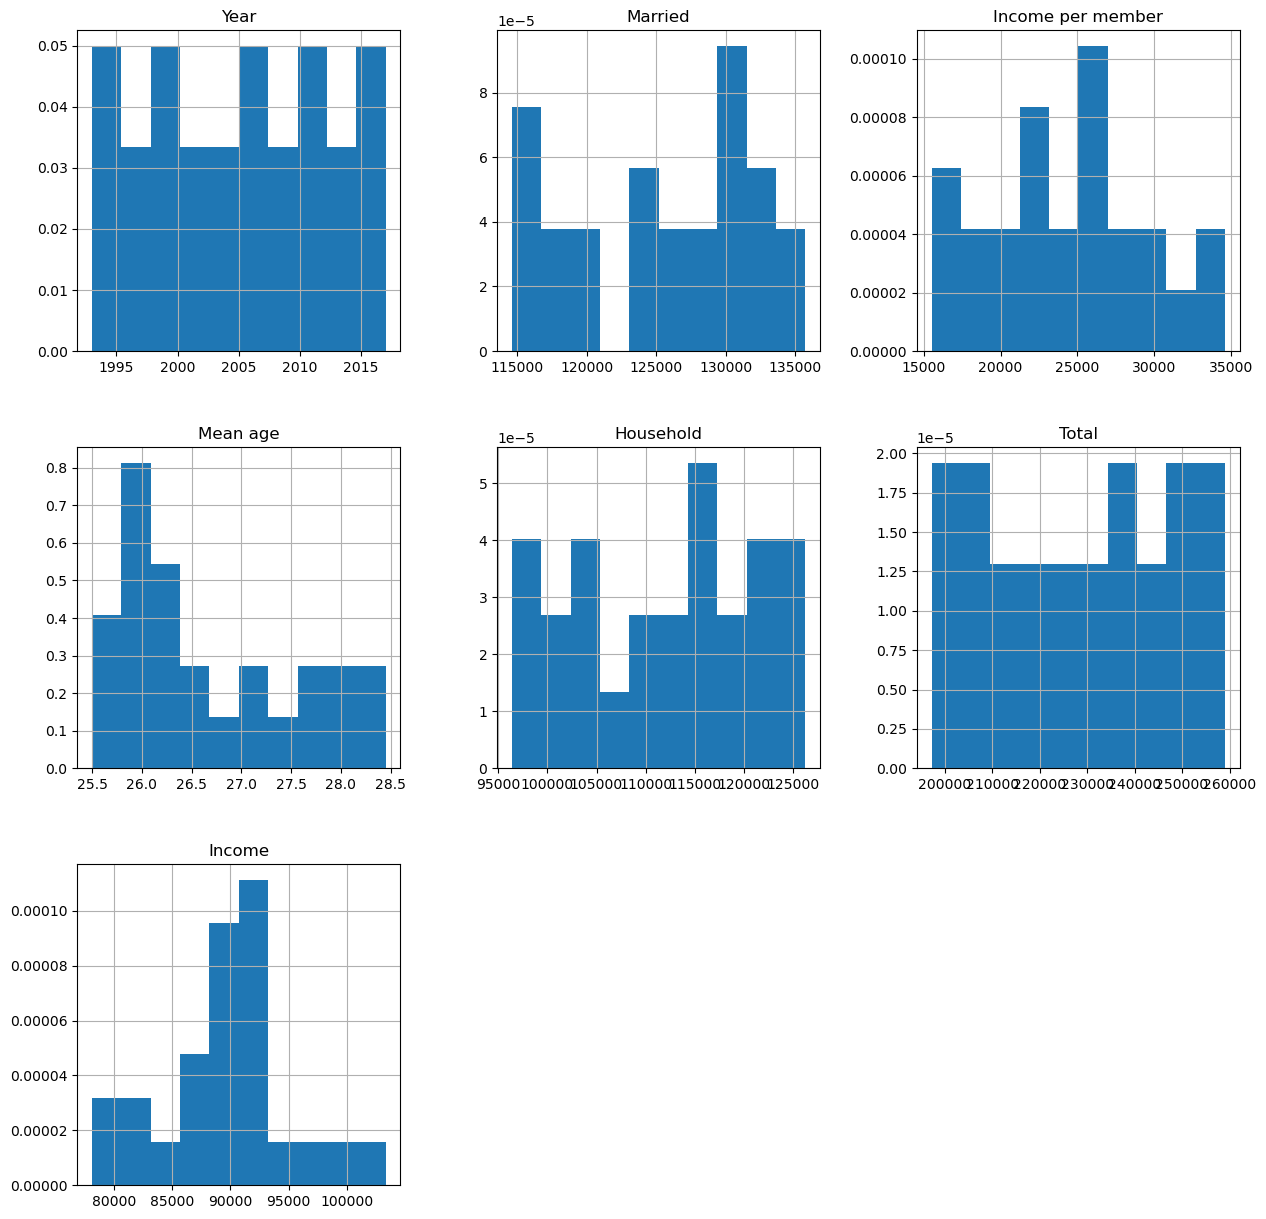

In [297]:
df.hist(figsize=(15,15), bins=10, density=True)
plt.show()

In [259]:
import warnings
import cmdstanpy
warnings.filterwarnings('ignore')
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### 3. Utworzenie modeli

- Mamy 2 modele - jeden przewidujący liczbę/procent osób po ślubie na podstawie samych danych o przychodzie oraz drugi - przewidujący liczbę/procent osób po ślubie na podstawie przychodu, wieku??? oraz liczby obecnych miejsc zamieszkania

- Modele różnią się liczbą przyjętych predyktorów

- Większa liczba predyktorów może przyczynić się do otrzymania lepszych, bardziej zbliżonych do rzeczwistości wyników

- ??????are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]

In [260]:
model_1_prior = CmdStanModel(stan_file='model_prior.stan')
model_1_posterior = CmdStanModel(stan_file='model.stan')
model_2_prior = CmdStanModel(stan_file='triparam_model.stan')
model_2_posterior = CmdStanModel(stan_file='triparam_model_posterior.stan')

N = 25
R = 100

12:54:07 - cmdstanpy - INFO - compiling stan file C:\Users\Julia\Desktop\Data analysis\Project\DA_project\model_prior.stan to exe file C:\Users\Julia\Desktop\Data analysis\Project\DA_project\model_prior.exe
12:54:31 - cmdstanpy - INFO - compiled model executable: C:\Users\Julia\Desktop\Data analysis\Project\DA_project\model_prior.exe
12:54:31 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
12:54:31 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Julia/Desktop/DATAAN~1/Project/DA_PRO~1/model_prior.hpp C:/Users/Julia/Desktop/DATAAN~1/Project/DA_PRO~1/model_prior.stan
Warning in 'C:/Users/Julia/Desktop/DATAAN~1/Project/DA_PRO~1/model_prior.stan', line 9, column 26: fabs
    is deprecated and will be removed in Stan 2.33.0. Use abs instead. This
    can be automatically changed using the canonicalize flag for stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialize

### 4. Priors

- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

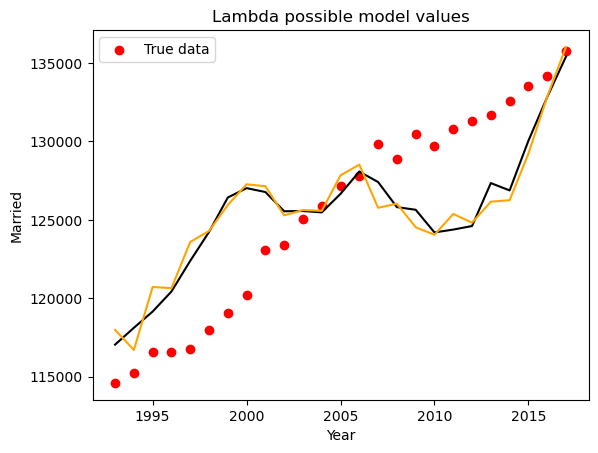

In [261]:
from numpy import random
beta = 60000
alpha = 0.73

v = random.poisson(alpha*df['Income'] + beta)
v = random.normal(alpha*df['Income'] + beta, 1000)

plt.scatter(df['Year'], df['Married'], color='red', label="True data")
plt.plot(df['Year'], alpha*df['Income'] + beta, color='black')
plt.plot(df['Year'], v, color='orange')

plt.title('Lambda possible model values')
plt.xlabel('Year')
plt.ylabel('Married')
plt.legend()
plt.show()

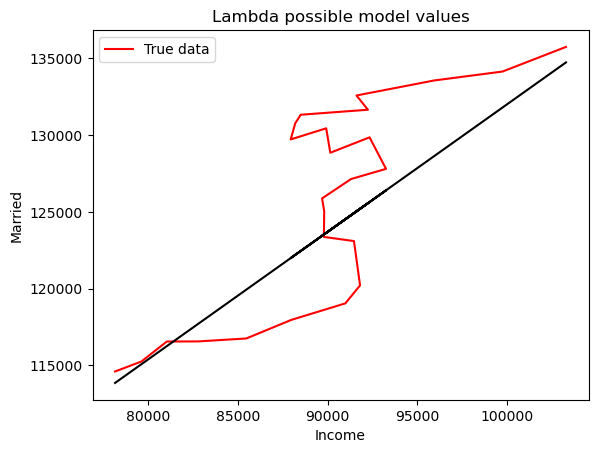

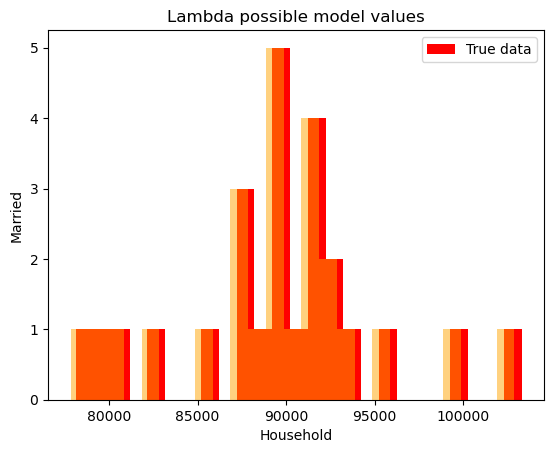

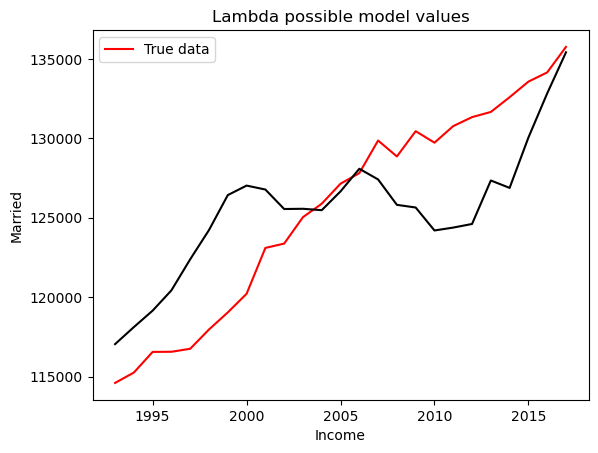

In [262]:
alpha_i = 0.83
beta_i = 49000

import matplotlib.pyplot as plt
import numpy as np



plt.plot(df['Income'],df['Married'], color='red', label="True data")
plt.plot(df['Income'], alpha_i*df['Income'] + beta_i, color='black')


plt.title('Lambda possible model values')
plt.xlabel('Income')
plt.ylabel('Married')
plt.legend()
plt.show()

v = random.normal(alpha_i*1.2*df['Income'] + beta_i-49000,1)
plt.hist(df['Income'], color='red', label="True data", bins=25)
plt.hist(v, color='orange', alpha=0.5, bins=25)

plt.title('Lambda possible model values')
plt.xlabel('Household')
plt.ylabel('Married')
plt.legend()
plt.show()

plt.plot(df['Year'],df['Married'], color='red', label="True data")
plt.plot(df['Year'], alpha*df['Income'] + beta, color='black')
plt.title('Lambda possible model values')
plt.xlabel('Income')
plt.ylabel('Married')
plt.legend()
plt.show()

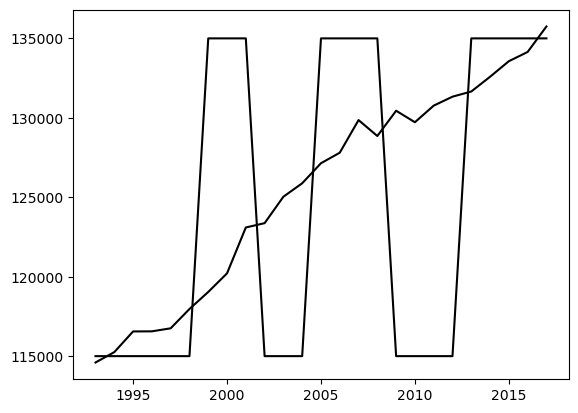

In [263]:
def sigmoid(x):
  a = 20000
  b = 90000
  c = 115000
  return a / (1 + np.exp(-(x-b))) +c

# plt.scatter(df['Income'],df['Married'], color='red', label="True data")
# plt.plot(df['Income'] , sigmoid(df['Income']), color='black')

plt.plot(df['Year'] , df['Married'] , color='black')
plt.plot(df['Year'] , sigmoid(df['Income']), color='black')
plt.show()


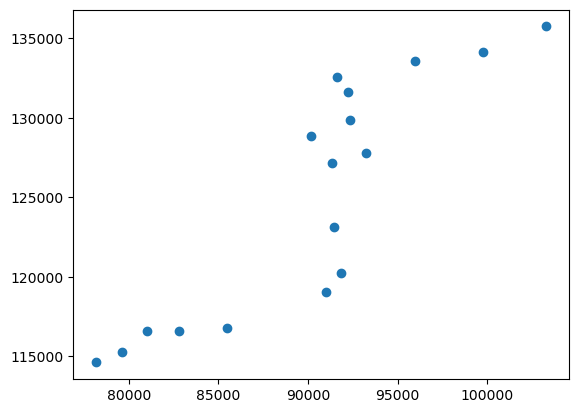

In [264]:
new = df[['Income','Married']][df['Income'] < 90000]
new = pd.concat([df[['Income','Married']][df['Income'] < 87000], df[['Income','Married']][df['Income'] > 90000]])

plt.scatter(new['Income'], new['Married'], label='Data Points')

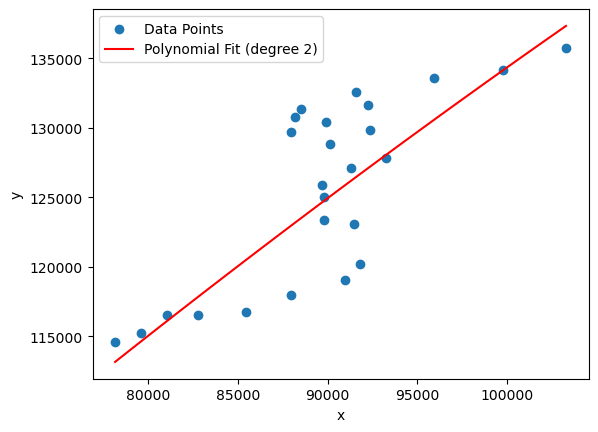

In [265]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data points
x = new['Income']
y = new['Married']

# Fit a polynomial of degree 2 (quadratic) to the data
degree = 2
coefficients = np.polyfit(x, y, degree)

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the fitted polynomial
x_fit = np.linspace(min(x), max(x), 100)
y_fit = polynomial(x_fit)

# Plot the original data points
plt.scatter(df['Income'], df['Married'], label='Data Points')

# Plot the fitted polynomial
plt.plot(x_fit, y_fit, label=f'Polynomial Fit (degree {degree})', color='red')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

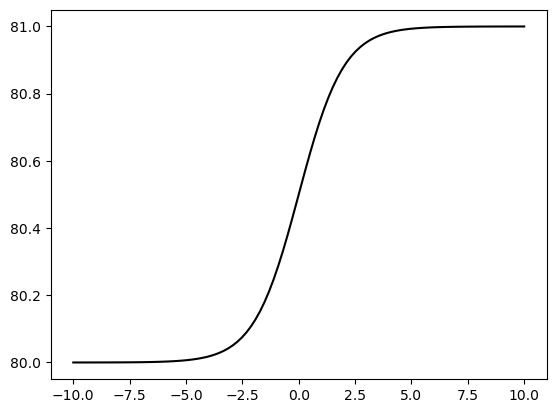

In [266]:
x = np.linspace(-10, 10, 100)
plt.plot(x , 1 / (1 + np.exp(-x)) + 80, color='black')

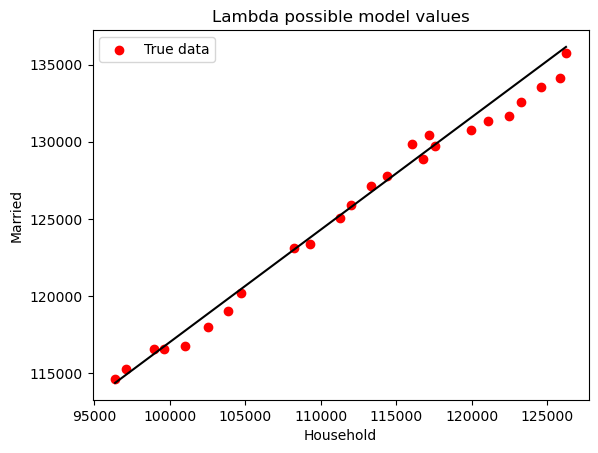

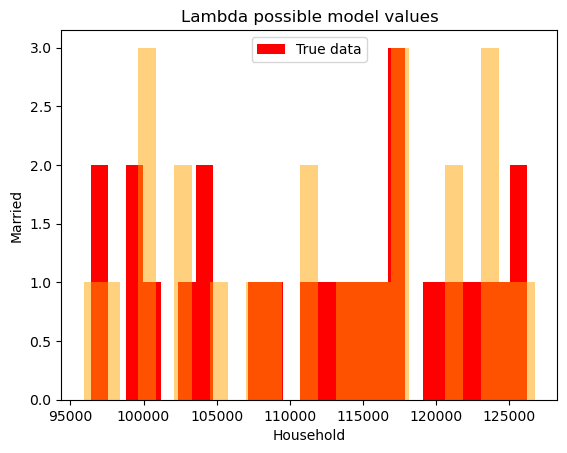

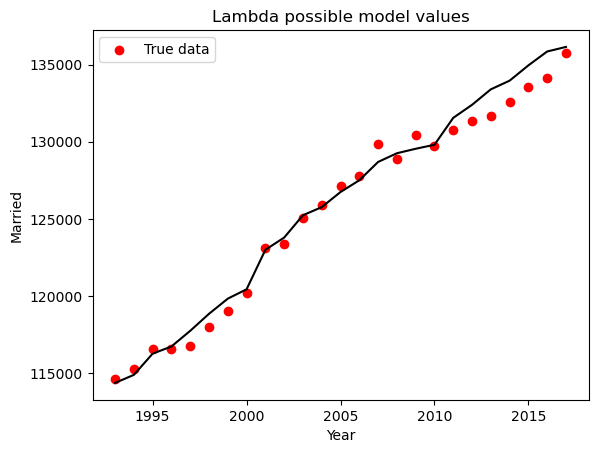

In [267]:

alpha_h = 0.73
beta_h = 44000

plt.scatter(df['Household'], df['Married'], color='red', label="True data")
plt.plot(df['Household'], alpha_h*df['Household'] + beta_h, color='black')
plt.title('Lambda possible model values')
plt.xlabel('Household')
plt.ylabel('Married')
plt.legend()
plt.show()

v = random.normal(alpha_h*1.35*df['Household'] + beta_h-42500,1000)
plt.hist(df['Household'], color='red', label="True data", bins=25)
plt.hist(v, color='orange', alpha=0.5, bins=25)

plt.title('Lambda possible model values')
plt.xlabel('Household')
plt.ylabel('Married')
plt.legend()
plt.show()

plt.scatter(df['Year'], df['Married'], color='red', label="True data")
plt.plot(df['Year'], alpha_h*df['Household'] + beta_h, color='black')
plt.title('Lambda possible model values')
plt.xlabel('Year')
plt.ylabel('Married')
plt.legend()
plt.show()

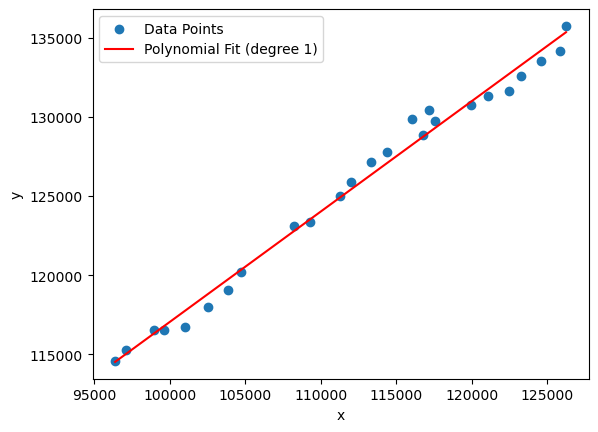

(0.6982083801087531, 47218.03491943042)

In [268]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data points
x = df['Household']
y = df['Married']

# Fit a polynomial of degree 2 (quadratic) to the data
degree = 1
coefficients = np.polyfit(x, y, degree)

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the fitted polynomial
x_fit = np.linspace(min(x), max(x), 100)
y_fit = polynomial(x_fit)

# Plot the original data points
plt.scatter(x, y, label='Data Points')

# Plot the fitted polynomial
plt.plot(x_fit, y_fit, label=f'Polynomial Fit (degree {degree})', color='red')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
coefficients[0], coefficients[1]

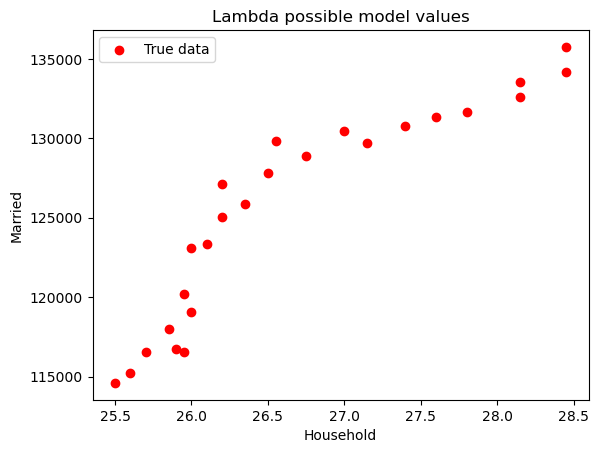

In [269]:
plt.scatter(df['Mean age'], df['Married'], color='red', label="True data")
# plt.plot(df['Mean age'], alpha*df['Mean age'] + beta, color='black')
# plt.scatter(df['Household'], v, color='orange')

plt.title('Lambda possible model values')
plt.xlabel('Household')
plt.ylabel('Married')
plt.legend()
plt.show()

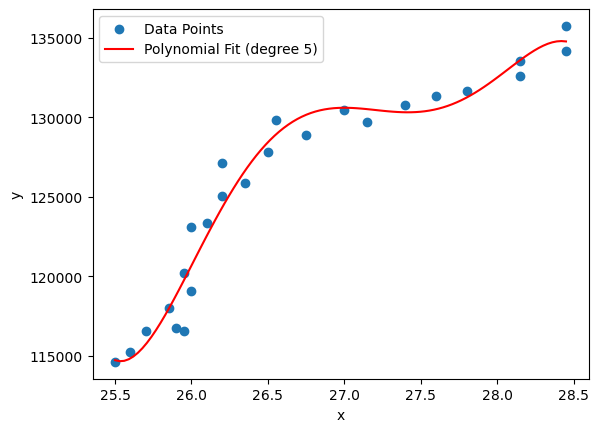

(-2373.0624146425953,
 321464.15777801373,
 -17410214.256129496,
 471227890.5600212,
 -6373970270.137061)

In [270]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data points
x = df['Mean age']
y = df['Married']

# Fit a polynomial of degree 2 (quadratic) to the data
degree = 5
coefficients = np.polyfit(x, y, degree)

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the fitted polynomial
x_fit = np.linspace(min(x), max(x), 100)
y_fit = polynomial(x_fit)

# Plot the original data points
plt.scatter(x, y, label='Data Points')

# Plot the fitted polynomial
plt.plot(x_fit, y_fit, label=f'Polynomial Fit (degree {degree})', color='red')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
coefficients[0], coefficients[1], coefficients[2], coefficients[3],coefficients[4]

In [271]:
data = {'N': N, 'income': df['Income']}
gen_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

12:54:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


12:54:41 - cmdstanpy - INFO - CmdStan done processing.


In [272]:
gen_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.100820,51554.4,363.866,137619.0,138685.0,140843.0,143116.0,146454.0,...,150896.0,150514.0,148402.0,148868.0,149301.0,153018.0,152435.0,156557.0,161408.0,165032.0
1,0.0,0.0,0.948083,49714.1,920.009,124385.0,125586.0,123926.0,129149.0,131220.0,...,135423.0,133694.0,132593.0,133075.0,134322.0,137437.0,137160.0,139580.0,144289.0,147648.0
2,0.0,0.0,0.951486,51519.1,1369.850,127482.0,128929.0,129701.0,131335.0,130595.0,...,135469.0,138059.0,137604.0,134972.0,133094.0,139802.0,138843.0,141528.0,147897.0,149776.0
3,0.0,0.0,0.867027,48823.4,1448.920,117246.0,116662.0,118855.0,117856.0,121472.0,...,125477.0,126642.0,126960.0,125177.0,124937.0,127157.0,126481.0,134067.0,135045.0,138155.0
4,0.0,0.0,0.890513,50787.9,1441.340,117308.0,121999.0,119697.0,123628.0,125628.0,...,129831.0,131501.0,130049.0,130026.0,127787.0,134370.0,133295.0,134657.0,141065.0,142889.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.930667,49507.6,532.655,121840.0,123457.0,125098.0,127330.0,128925.0,...,132932.0,133665.0,131053.0,132042.0,131702.0,135731.0,135076.0,138118.0,141704.0,144937.0
96,0.0,0.0,0.769859,51263.6,809.024,111649.0,114216.0,112079.0,113574.0,117627.0,...,119676.0,121063.0,119350.0,118536.0,118674.0,121974.0,122231.0,124450.0,128385.0,130779.0
97,0.0,0.0,0.954008,49943.7,1203.580,124671.0,126692.0,127269.0,130656.0,128858.0,...,136568.0,136674.0,134672.0,133787.0,134752.0,138156.0,137206.0,141196.0,145482.0,147668.0
98,0.0,0.0,0.748512,48461.9,504.891,106997.0,108732.0,110079.0,111225.0,112483.0,...,115937.0,115270.0,114710.0,114674.0,114657.0,117492.0,116887.0,120539.0,123008.0,125589.0


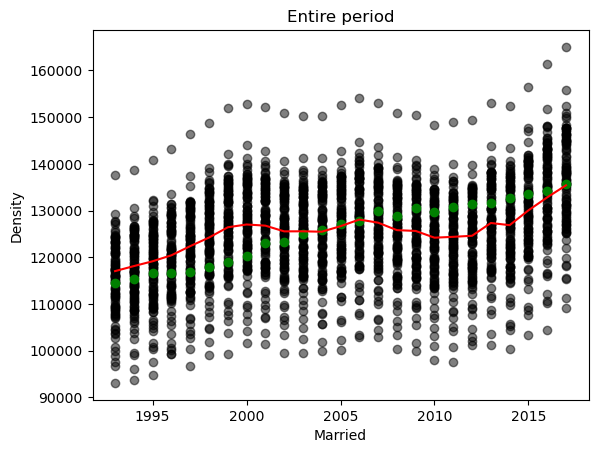

In [273]:
# UWAGA - lata są od największych w dół

for i in range(len(gen_1.y_sim)):
    plt.scatter(df['Year'], gen_1.y_sim[i], color='black', alpha = 0.5)

plt.plot(df['Year'], alpha*df['Income'] + beta, color='red') 
plt.scatter(df['Year'], df['Married'], color='green')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

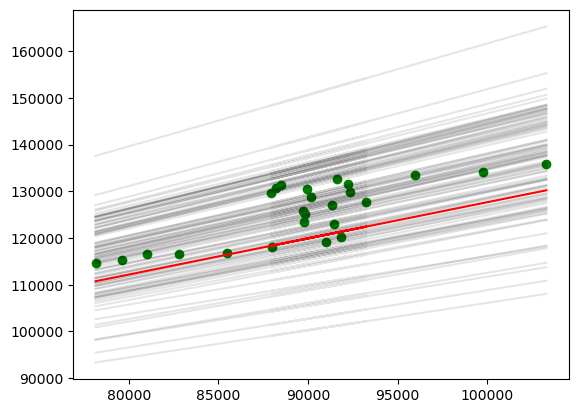

In [274]:
for i in range(len(gen_1.y_sim)):
    plt.plot(df['Income'], gen_1.alpha[i]*df['Income'] + gen_1.beta[i], color='black', alpha = 0.1)
plt.plot(df['Income'], gen_1.alpha[i].mean()*df['Income'] + gen_1.beta.mean(), color='red')   
plt.scatter(df['Income'], df['Married'], color='green')
plt.show()

In [275]:
data_post = {'N': N, 'y': df['Married'], 'income': df['Income']}
fit_1 = model_1_posterior.sample(
                    data=data_post, chains=1,
                    iter_sampling=R)

12:54:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                     


12:54:43 - cmdstanpy - INFO - CmdStan done processing.


In [276]:
fit_1.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,log_lik[16],log_lik[17],log_lik[18],log_lik[19],log_lik[20],log_lik[21],log_lik[22],log_lik[23],log_lik[24],log_lik[25]
0,-6737.14,0.798429,0.031299,5.0,51.0,0.0,6737.74,0.583433,73344.8,4110.28,...,-9.49145,-9.87707,-10.00100,-10.2947,-10.4341,-9.83671,-10.2330,-9.77195,-9.43978,-9.37516
1,-6737.05,0.943652,0.031299,5.0,51.0,0.0,6739.65,0.562181,75301.0,4095.41,...,-9.48269,-9.86562,-9.97671,-10.2698,-10.4107,-9.83857,-10.2334,-9.79335,-9.46378,-9.40467
2,-6737.37,1.000000,0.031299,3.0,15.0,0.0,6738.56,0.566559,74905.9,4082.34,...,-9.48114,-9.86685,-9.98128,-10.2764,-10.4180,-9.83687,-10.2345,-9.78726,-9.45519,-9.39450
3,-6735.37,0.551041,0.031299,2.0,3.0,0.0,6740.70,0.562654,74626.0,4083.77,...,-9.60220,-10.05260,-10.17940,-10.5085,-10.6649,-10.02130,-10.4672,-9.96874,-9.57799,-9.50371
4,-6736.63,0.908375,0.031299,2.0,3.0,0.0,6736.85,0.561862,74580.2,4084.72,...,-9.62728,-10.08950,-10.21840,-10.5537,-10.7128,-10.05800,-10.5128,-10.00520,-9.60386,-9.52723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-6734.12,0.934566,0.031299,5.0,39.0,0.0,6736.88,0.551891,75940.9,4121.75,...,-9.53706,-9.94357,-10.05350,-10.3579,-10.5044,-9.92194,-10.3328,-9.88459,-9.53452,-9.47334
96,-6734.02,0.999730,0.031299,3.0,15.0,0.0,6734.25,0.549239,76135.7,4121.42,...,-9.54535,-9.95624,-10.06550,-10.3722,-10.5200,-9.93617,-10.3503,-9.90115,-9.54758,-9.48653
97,-6734.18,0.995381,0.031299,5.0,43.0,0.0,6734.49,0.566855,74386.2,4113.93,...,-9.57596,-10.00590,-10.13040,-10.4473,-10.5980,-9.97300,-10.4022,-9.91837,-9.54536,-9.47380
98,-6733.92,0.996530,0.031299,6.0,63.0,0.0,6734.31,0.559851,75032.2,4144.20,...,-9.57556,-9.99734,-10.11520,-10.4266,-10.5753,-9.96971,-10.3910,-9.92312,-9.55820,-9.49058


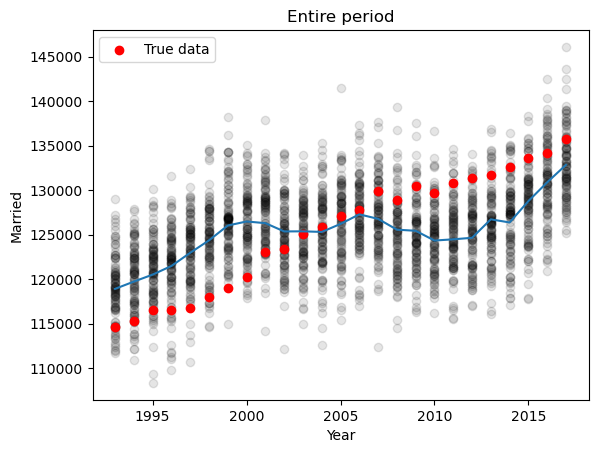

In [277]:
for i in range(len(fit_1.y_sim)):
    plt.scatter(df['Year'], fit_1.y_sim[i], alpha = 0.1, color="black")
plt.scatter(df['Year'], df['Married'], label= 'True data', color="red")
plt.plot(df['Year'], fit_1.alpha.mean()*df['Income'] + fit_1.beta.mean())
plt.title('Entire period')
plt.ylabel('Married')
plt.xlabel('Year')
plt.legend()
plt.show()

### 5. Posterior (model 1) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [278]:
az.summary(fit_1)

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.553,0.017,0.514,0.584,0.002,0.001,72.0,57.0,NaN
beta,75672.824,1552.547,72425.300,78477.700,183.345,130.703,70.0,57.0,NaN
sigma,4107.021,56.075,3993.900,4209.950,30.253,23.527,3.0,25.0,NaN
y_sim[0],118967.230,3752.650,111652.000,125542.000,408.664,289.974,83.0,59.0,NaN
y_sim[1],119987.280,3845.194,113107.000,126746.000,425.058,301.639,85.0,54.0,NaN
y_sim[2],120936.290,3891.074,114985.000,128787.000,390.584,278.512,94.0,100.0,NaN
y_sim[3],121575.550,4156.584,111734.000,128529.000,336.487,241.148,139.0,78.0,NaN
y_sim[4],123164.570,3842.318,117170.000,130377.000,360.050,255.249,112.0,113.0,NaN
y_sim[5],124386.840,4240.374,114671.000,130656.000,453.330,321.983,86.0,117.0,NaN
y_sim[6],126617.090,4009.356,120403.000,134319.000,371.731,265.547,113.0,102.0,NaN


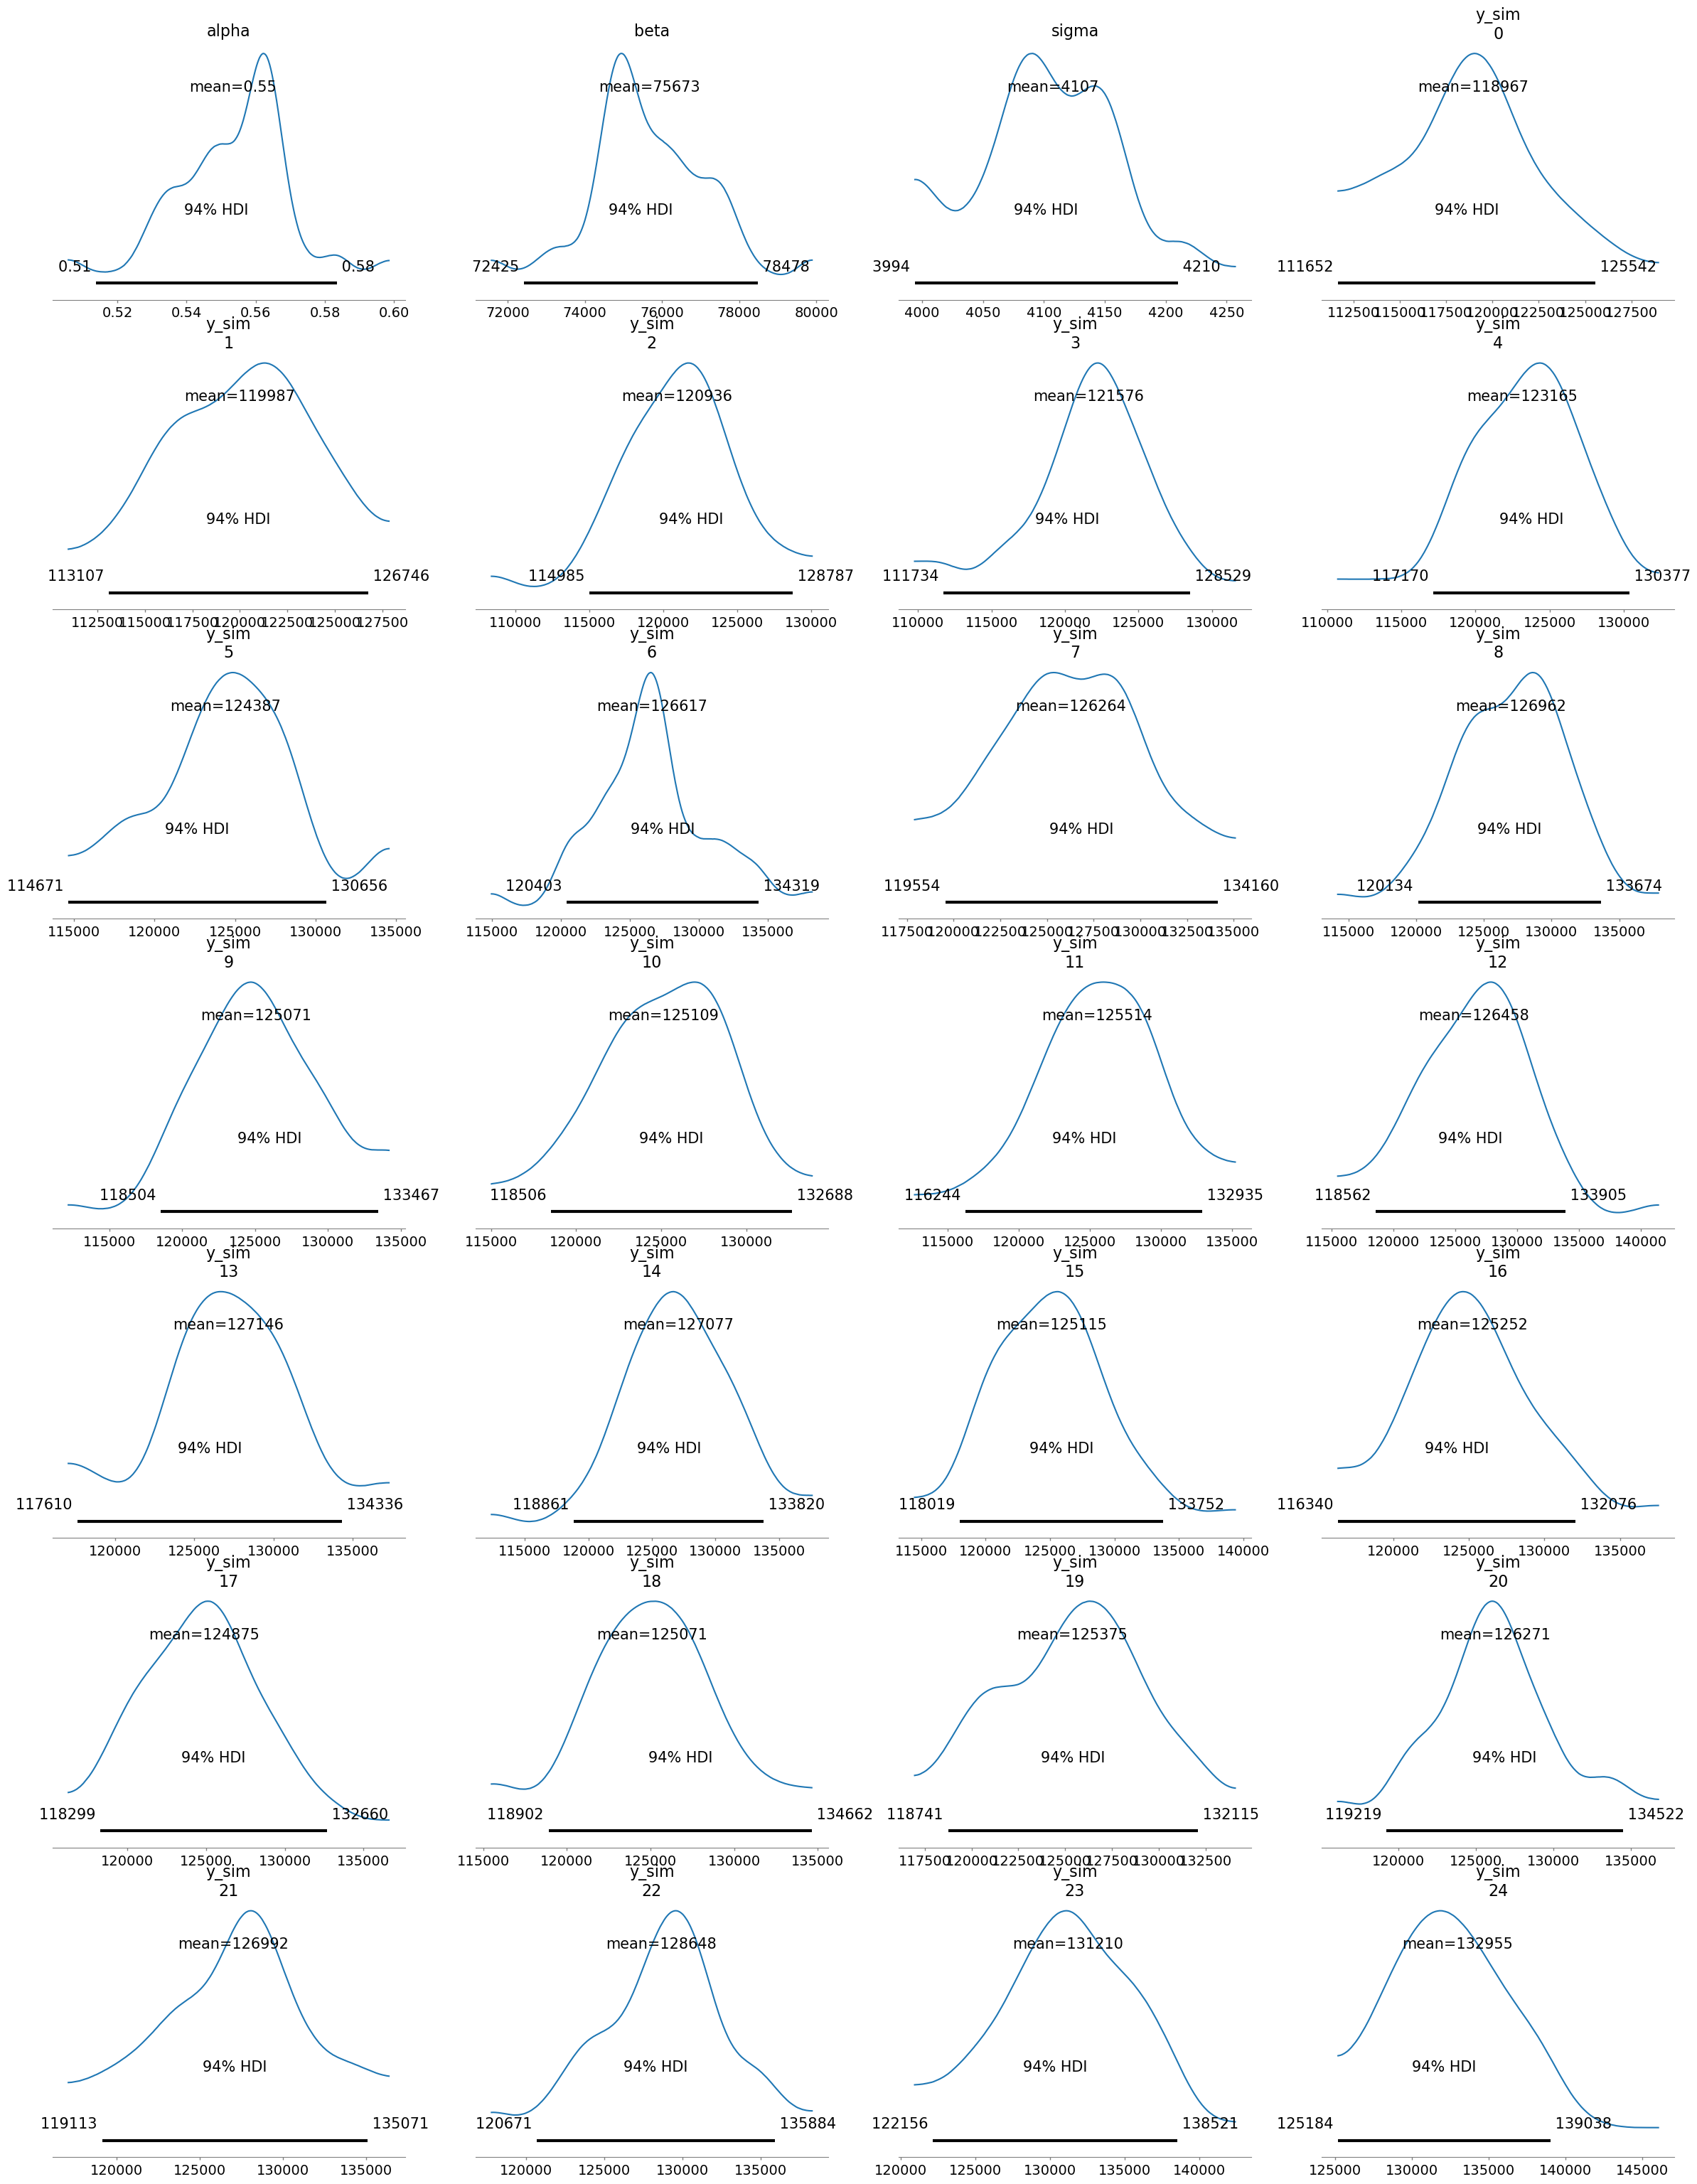

In [279]:
az.plot_posterior(fit_1)
plt.show()

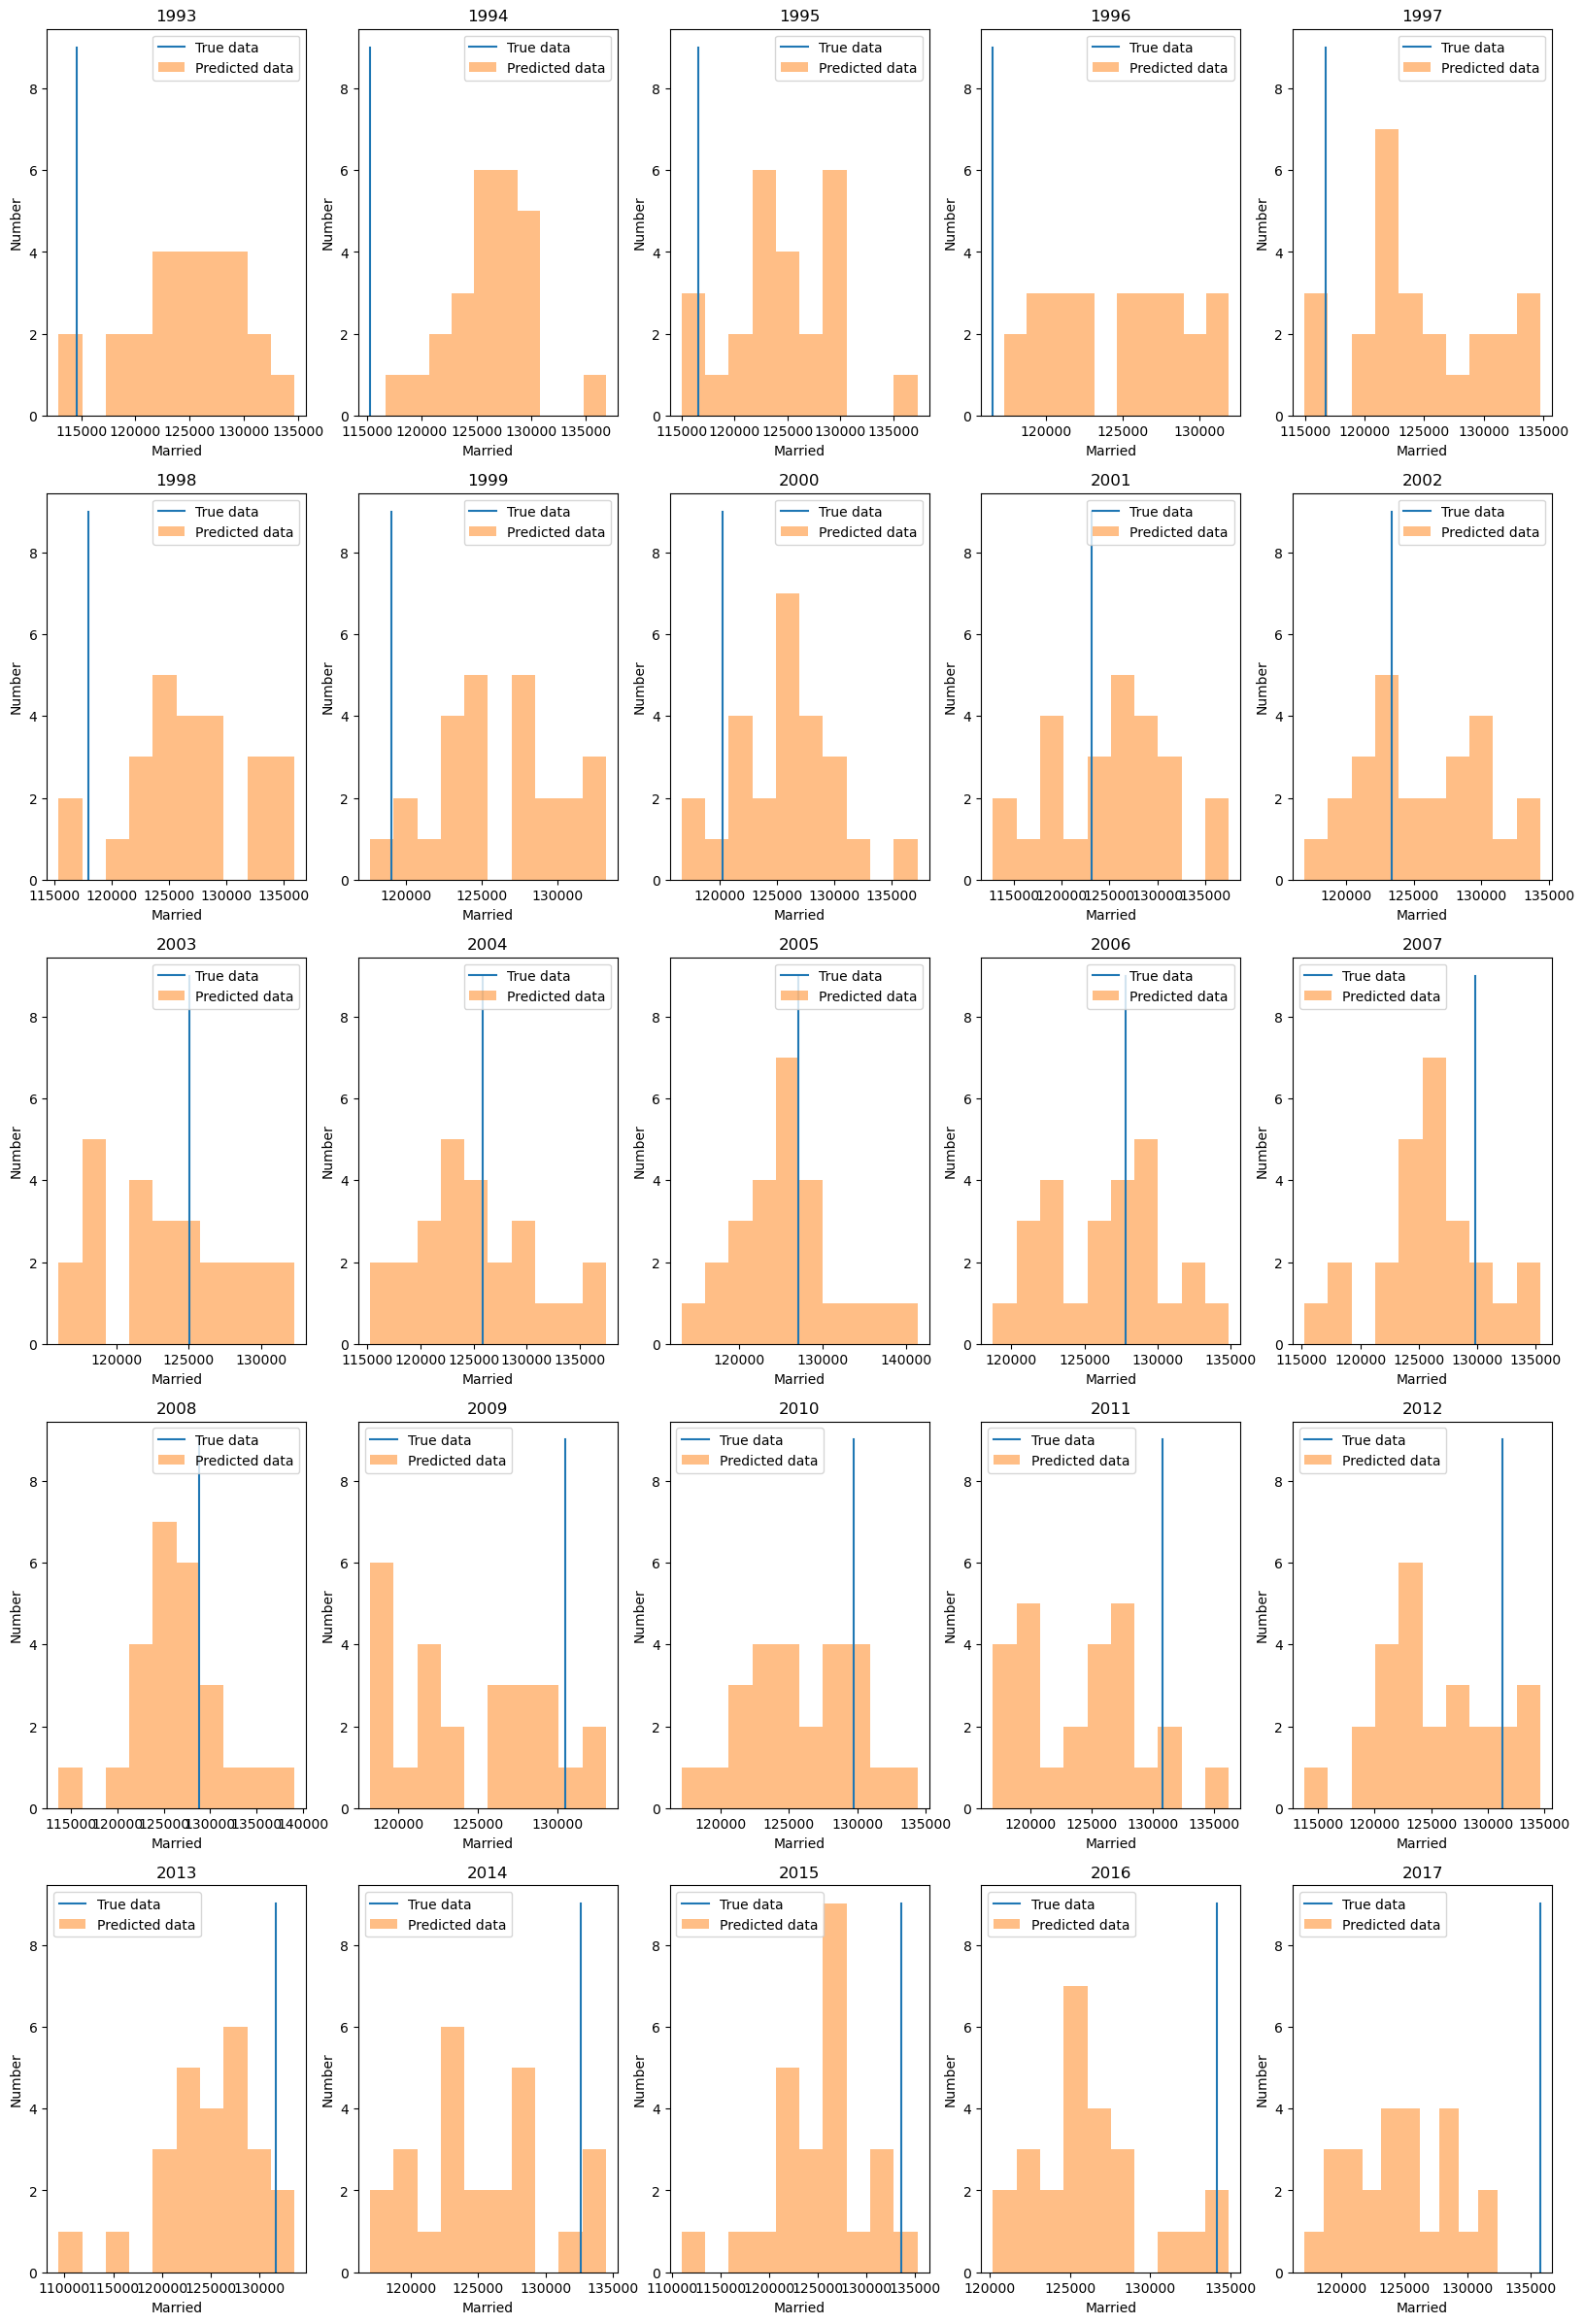

In [280]:
n=1
plt.figure(figsize=(20,30))
for i in range(len(df)):
    plt.subplot(5,5,n)
    plt.plot([df['Married'][i]]*10, range(0,10), label= 'True data')
    plt.hist(fit_1.y_sim[i], bins=10, alpha = 0.5, label = 'Predicted data')
    plt.title(df['Year'][i])
    plt.ylabel('Number')
    plt.xlabel('Married')
    plt.legend()
    n+=1

plt.show()

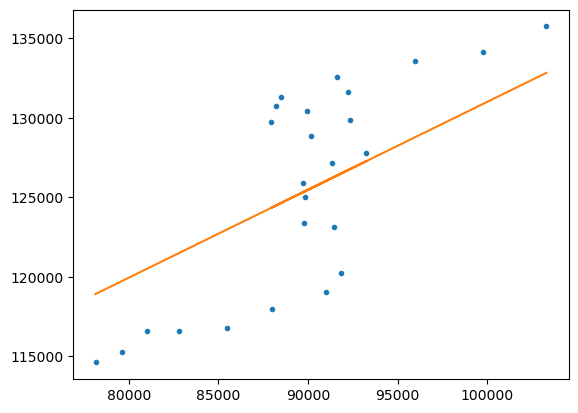

In [281]:
alpha = np.mean(fit_1.alpha)
beta = np.mean(fit_1.beta)
plt.plot(df['Income'], df['Married'],'.')
plt.plot(df['Income'], alpha*df['Income'] + beta) 
plt.show()

### 6. Posterior (model 2) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

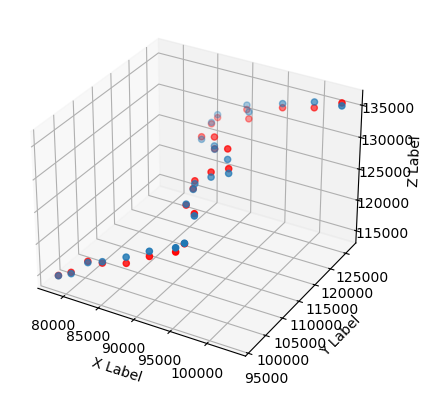

(47469.255907337756, -0.006672381254211546, 0.7013065093132285)

In [282]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Sample data
x = df['Income']
y = df['Household']
z = df['Married']


# Compute coefficients of the linear regression line manually
X = np.column_stack((np.ones_like(x), x, y))  # Add a column of ones for the intercept
coefficients = np.linalg.lstsq(X, z, rcond=None)[0]

# Extract coefficients
intercept, slope_x, slope_y = coefficients

# Define points for the line
z_line = intercept + slope_x * df['Income'] + slope_y * df['Household']

# # Plotting the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o')
ax.scatter(x, y, z_line)

# # # Plotting the linear regression line
# ax.plot_surface(x_line, y_line, z_line, alpha=0.5)

# Labeling the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
intercept, slope_x, slope_y

In [283]:
data = {'N': N,'income': df['Income'], 'household': df['Household']}
gen_1 = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

12:54:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


12:54:51 - cmdstanpy - INFO - CmdStan done processing.


In [284]:
data_post = {'N': N, 'y': df['Married'], 'income': df['Income'], 'household': df['Household']}
fit_2 = model_2_posterior.sample(
                    data=data_post, chains=1,
                    iter_sampling=R)


12:54:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


12:54:52 - cmdstanpy - INFO - CmdStan done processing.


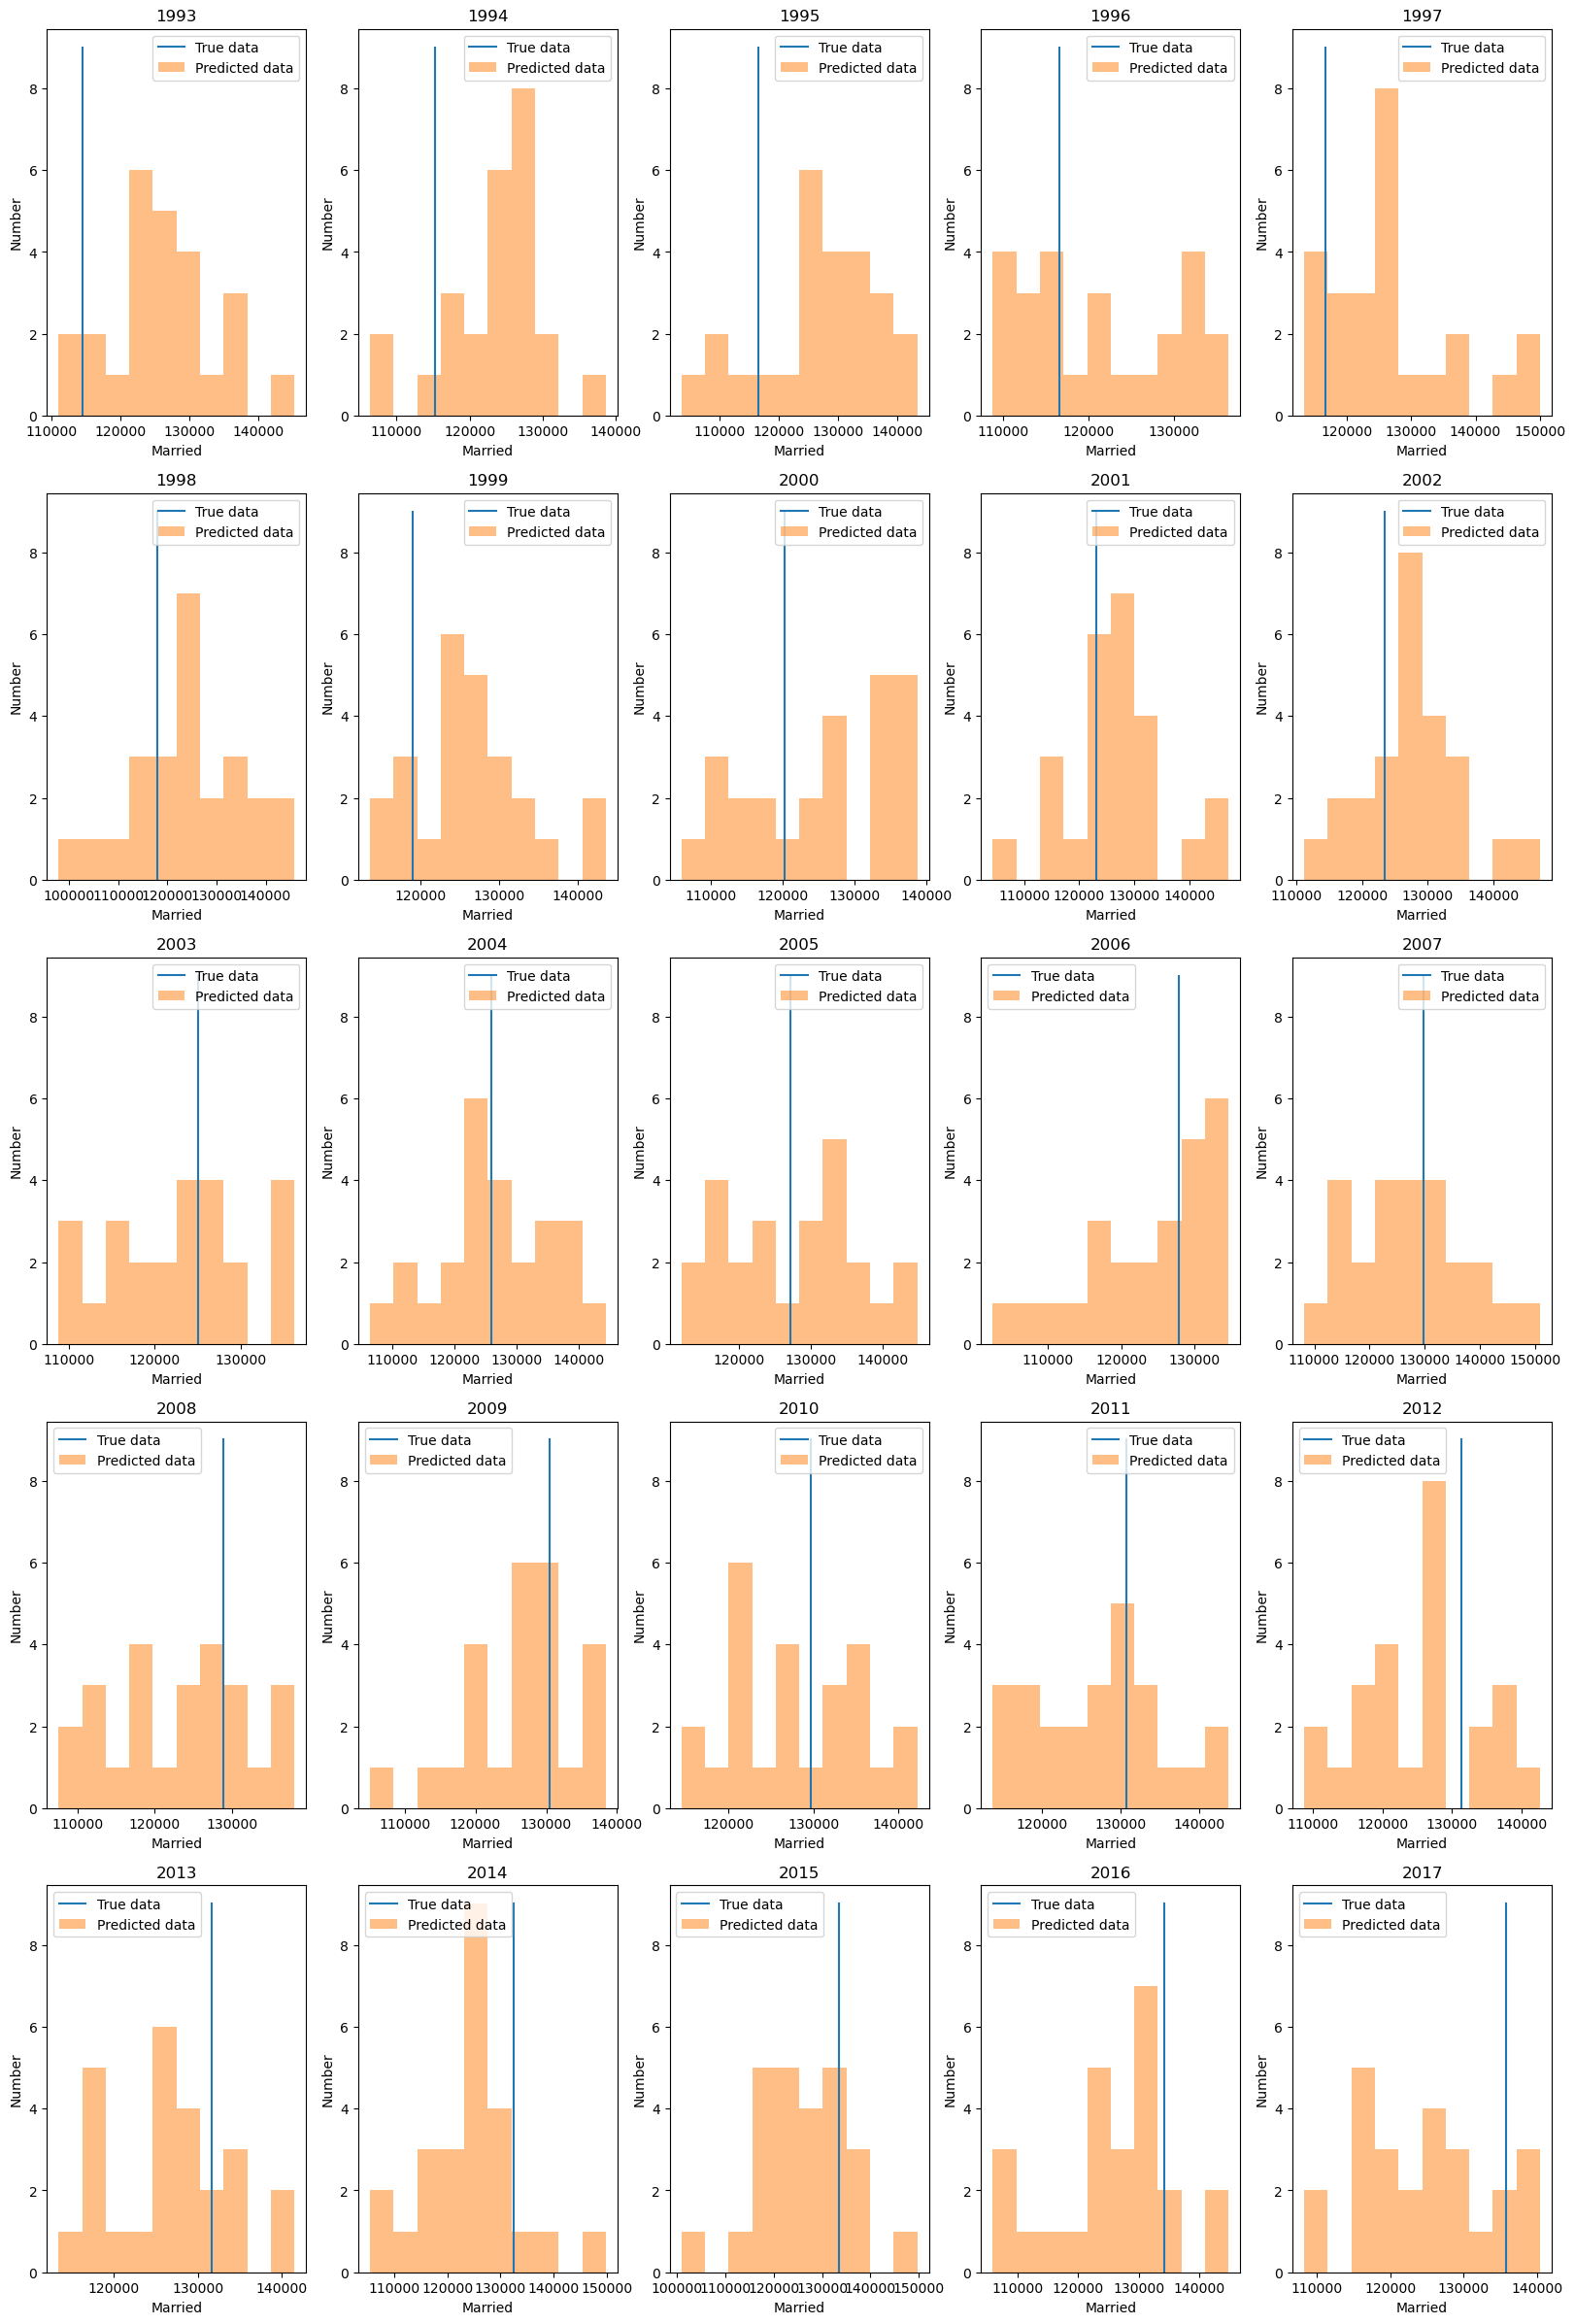

In [285]:
n=1
plt.figure(figsize=(20,30))
for i in range(len(df)):
    plt.subplot(5,5,n)
    plt.plot([df['Married'][i]]*10, range(0,10), label= 'True data')
    plt.hist(fit_2.y_sim[i], bins=10, alpha = 0.5, label = 'Predicted data')
    plt.title(df['Year'][i])
    plt.ylabel('Number')
    plt.xlabel('Married')
    plt.legend()
    n+=1

plt.show()

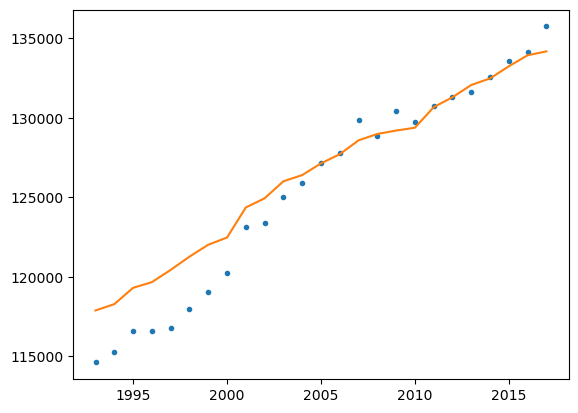

In [286]:
alpha1 = np.mean(fit_2.alpha_1)
alpha2 = np.mean(fit_2.alpha_2)
beta = np.mean(fit_2.beta)
plt.plot(df['Year'], df['Married'],'.')
plt.plot(df['Year'], alpha1*df['Income'] + alpha2*df['Household'] + beta) 
plt.show()

### 7. Porównanie modeli

- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

In [287]:
# Compare the models using WAIC
waic_compare = az.compare({"income": fit_1, "Income/household": fit_2}, ic="waic")

print("WAIC comparison:")
waic_compare


WAIC comparison:


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Income/household,0,-246.10102,0.012809,0.00000,0.601169,0.106684,0.000000,False,log
income,1,-246.64593,0.076396,0.54491,0.398831,2.256803,2.245853,False,log


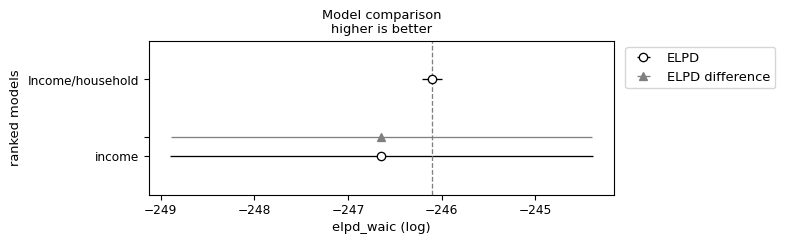

In [288]:
az.plot_compare(waic_compare)
plt.show()

In [289]:
# Compare the models using LOO
loo_compare = az.compare({"income": fit_1, "Income/household": fit_2}, ic="loo")

print("Loo comparison:")
loo_compare


Loo comparison:


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Income/household,0,-246.101157,0.012946,0.000000,0.601446,0.106703,0.000000,False,log
income,1,-246.647522,0.077988,0.546365,0.398554,2.256975,2.246018,False,log


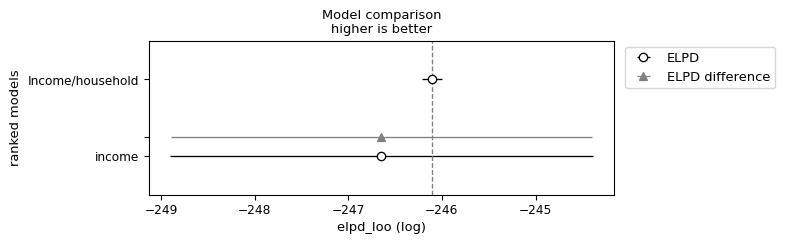

In [290]:

az.plot_compare(loo_compare)
plt.show()

12:54:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       


12:54:57 - cmdstanpy - INFO - CmdStan done processing.


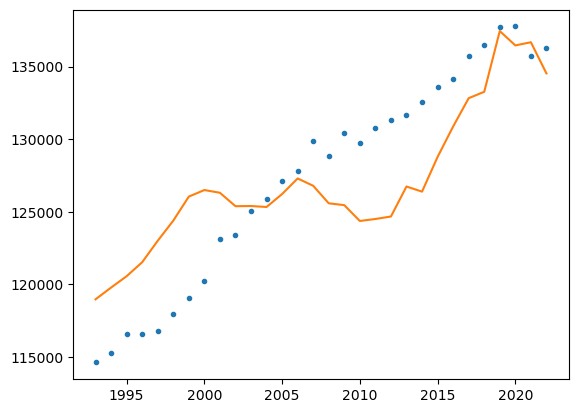

In [291]:
data_test = {'N': 30, 'y': df_all['Married'], 'income': df_all['Income']}
fit_test = model_1_posterior.sample(
                    data=data_post, chains=1,
                    iter_sampling=R)

alpha1 = np.mean(fit_test.alpha)

beta = np.mean(fit_test.beta)
plt.plot(df_all['Year'], df_all['Married'],'.')
plt.plot(df_all['Year'], alpha1*df_all['Income'] + beta) 
plt.show()



12:54:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                     


12:54:59 - cmdstanpy - INFO - CmdStan done processing.


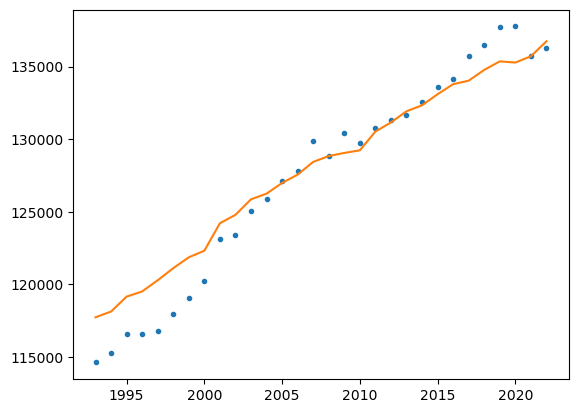

In [292]:
data_test = {'N': 30, 'y': df_all['Married'], 'income': df_all['Income'], 'household': df_all['Household']}
fit_test2 = model_2_posterior.sample(
                    data=data_post, chains=1,
                    iter_sampling=R)

alpha1 = np.mean(fit_test2.alpha_1)
alpha2 = np.mean(fit_test2.alpha_2)
beta = np.mean(fit_test2.beta)
plt.plot(df_all['Year'], df_all['Married'],'.')
plt.plot(df_all['Year'], alpha1*df_all['Income'] + alpha2*df_all['Household'] + beta) 
plt.show()

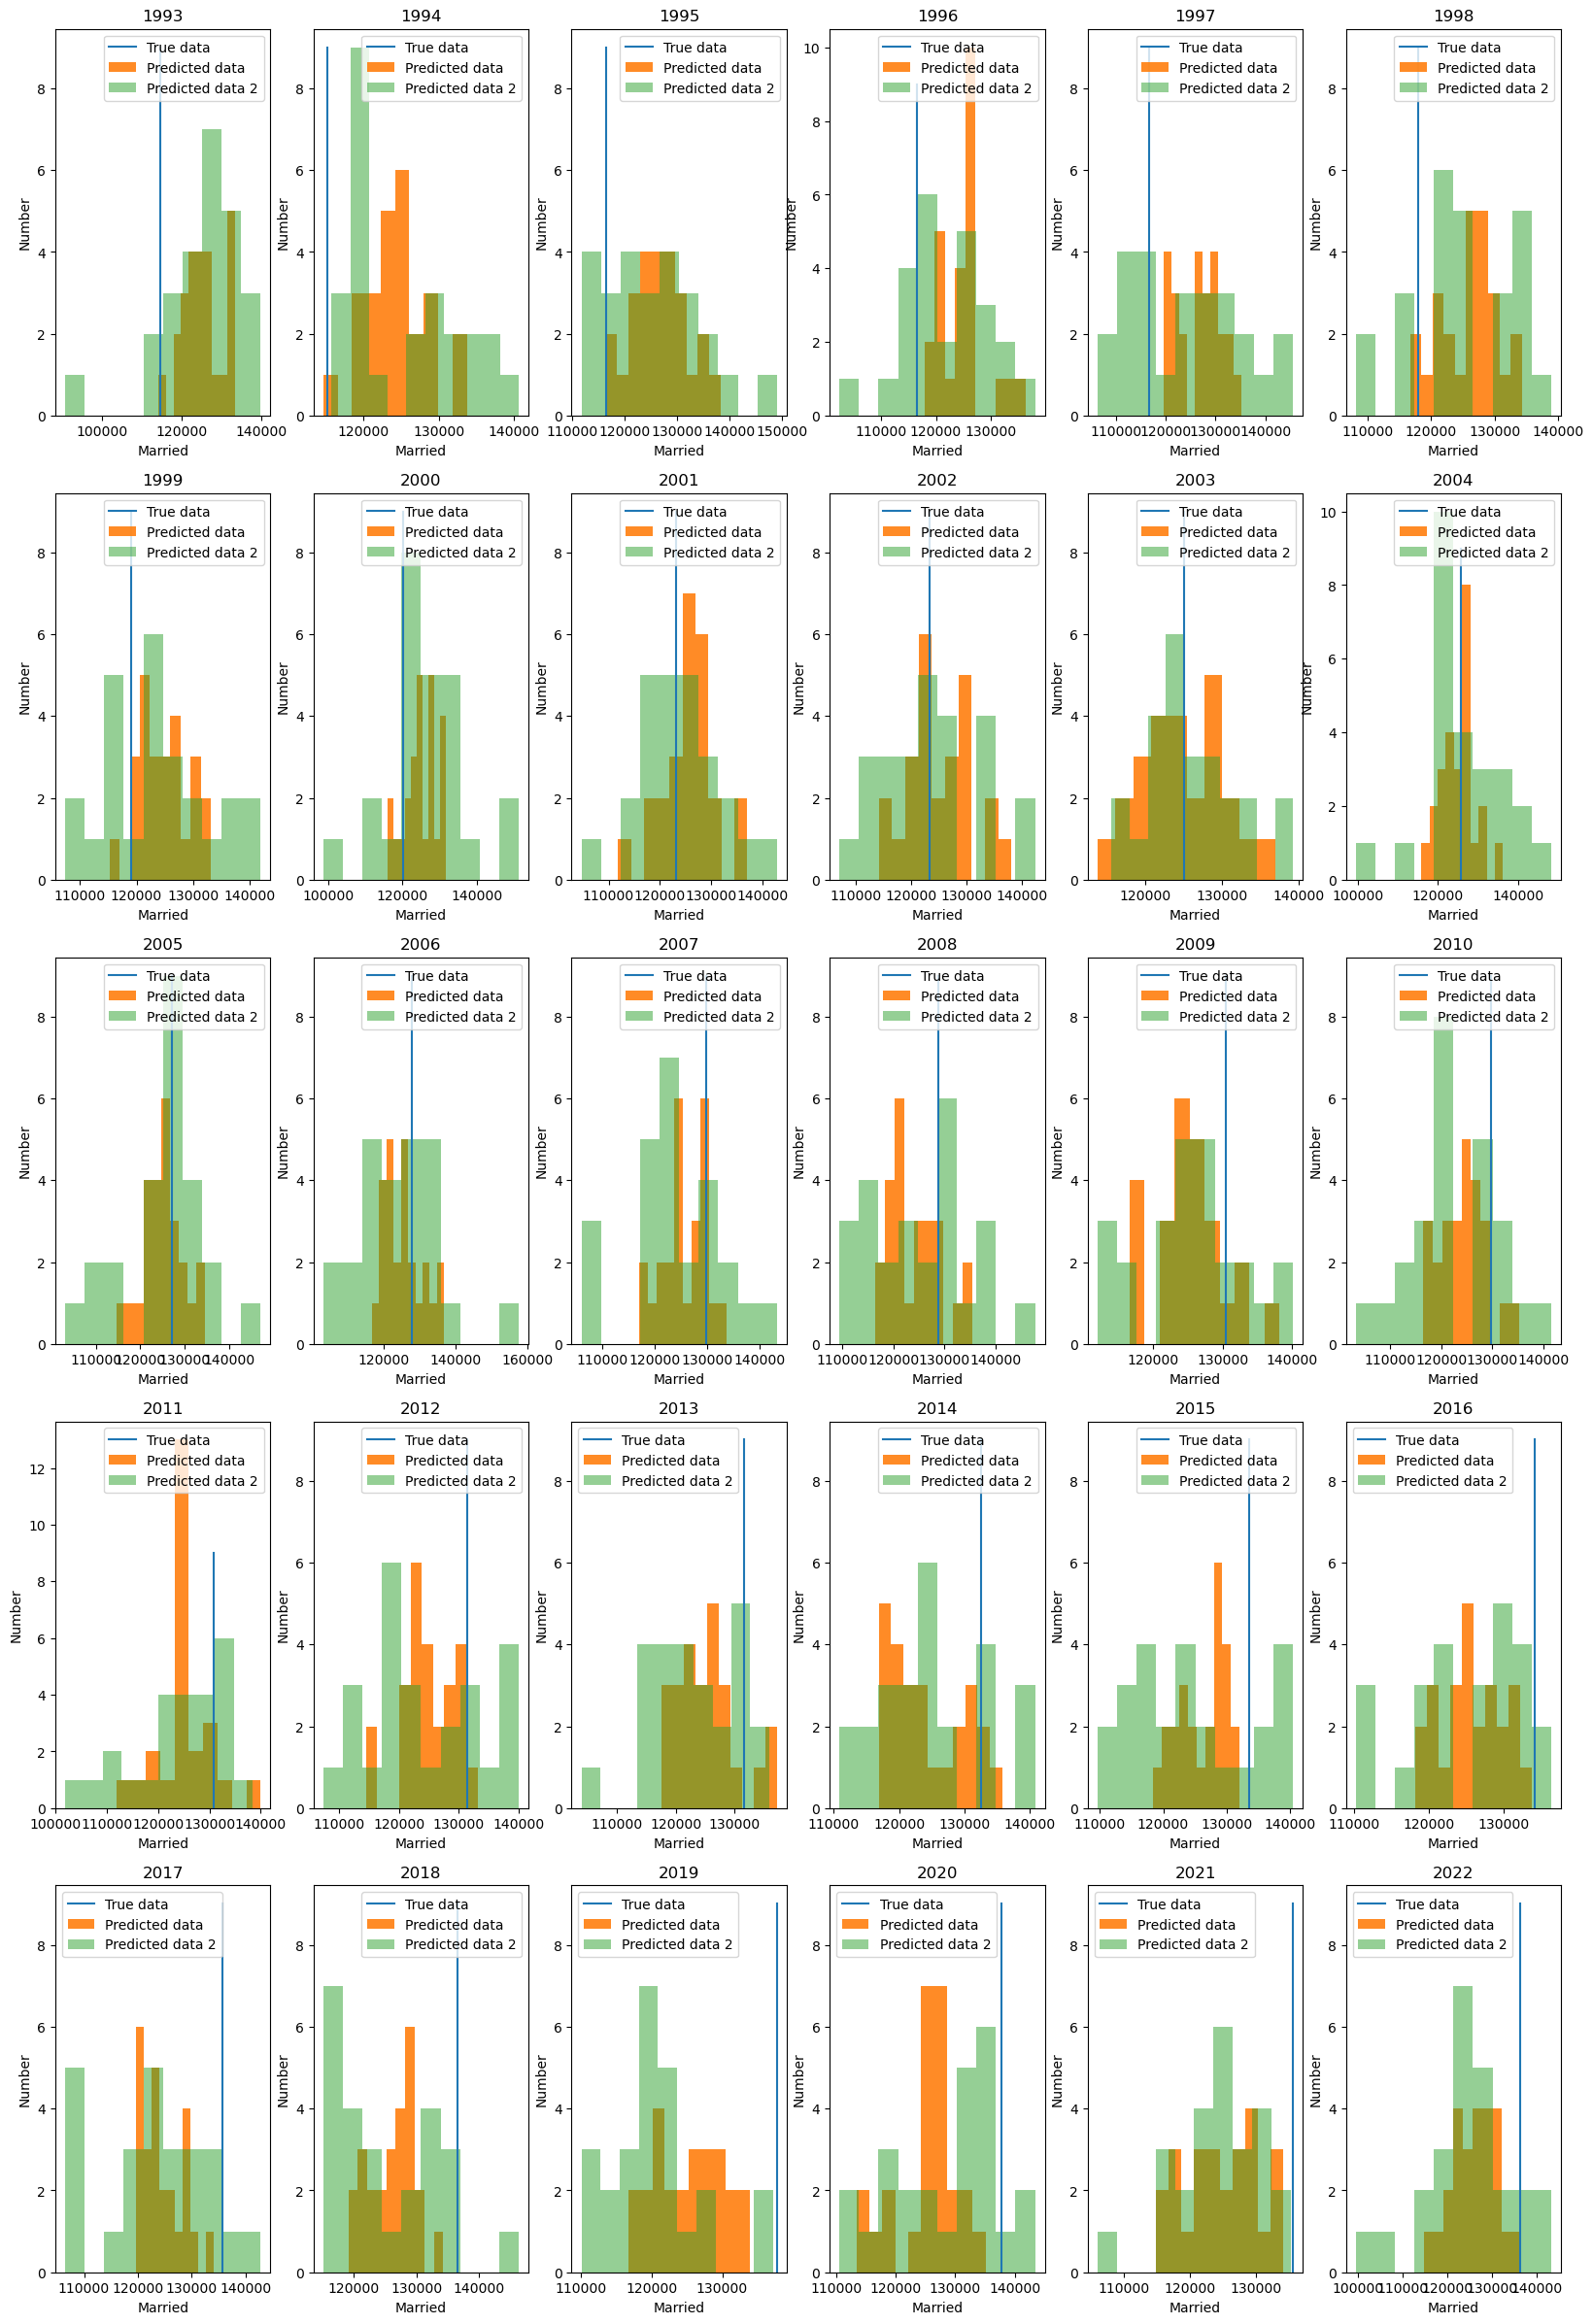

In [293]:
n=1
plt.figure(figsize=(20,30))
for i in range(len(df_all)):
    plt.subplot(5,6,n)
    plt.plot([df_all['Married'][i]]*10, range(0,10), label= 'True data')
    plt.hist(fit_test.y_sim[:][i], bins=10, alpha = 0.9, label = 'Predicted data')
    plt.hist(fit_test2.y_sim[:][i], bins=10, alpha = 0.5, label = 'Predicted data 2')
    plt.title(df_all['Year'][i])
    plt.ylabel('Number')
    plt.xlabel('Married')
    plt.legend()
    n+=1

plt.show()

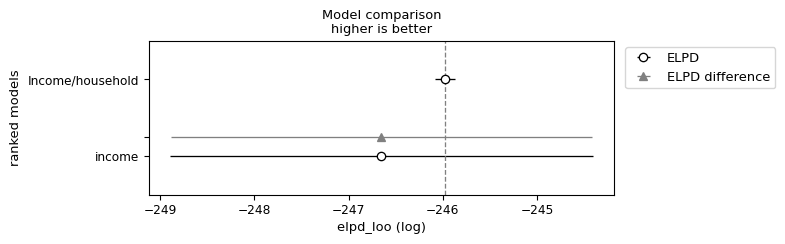

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Income/household,0,-245.974970,0.013617,0.000000,0.630305,0.108645,0.000000,False,log
income,1,-246.653435,0.076673,0.678465,0.369695,2.241484,2.233917,False,log


In [294]:
# Compare the models using LOO
loo_compare = az.compare({"income": fit_test, "Income/household": fit_test2}, ic="loo")

az.plot_compare(loo_compare)
plt.show()
loo_compare

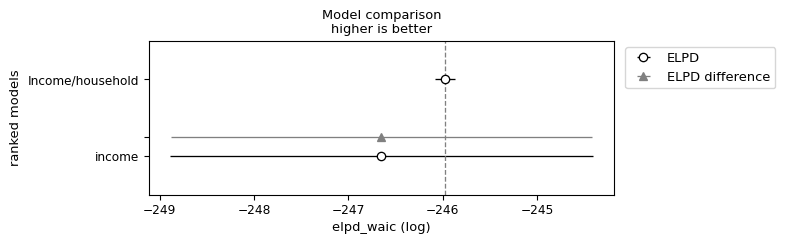

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Income/household,0,-245.974777,0.013424,0.000000,0.630092,0.108648,0.000000,False,log
income,1,-246.652149,0.075387,0.677372,0.369908,2.241356,2.233791,False,log


In [295]:
# Compare the models using WAIC
waic_compare = az.compare({"income": fit_test, "Income/household": fit_test2}, ic="waic")

az.plot_compare(waic_compare)
plt.show()
waic_compare